This code is based on the Matlab script written by C.A. Stock, NOAA GFDL used to generate Figure 11 in Stock et al., 2011

In [1]:
import numpy as np
import netCDF4 as nc
import pickle
from scipy.stats import ttest_ind, ttest_ind_from_stats, ttest_rel
import matplotlib.pyplot as plt
import matplotlib.dates as pltd
import matplotlib.colors as plt_col
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
warnings.filterwarnings("ignore")

In [2]:
def regress_drift_cor(var_val_all):
    
    # OPEN Pickle file and read in p-value and slope. These are the same across historical and future
    # Time periods
    pickle_fil = (nut_var + '_' + dst_sim + '_' + 'piC_0101-0351_stats.pkl')
    with open(pickle_fil,'rb') as f:  
        slope,p_value = pickle.load(f)
        
    ndim = np.ndim(var_val_all)
   
    # CORRECT FOR DRIFT
    drift_array = slope[:,:,ilon].squeeze()*(np.arange(var_val_all.shape[0]).reshape((np.append(var_val_all.shape[0],np.ones(ndim-1)).astype(int))) + 
                         mod_tims[nut_tim]['nt2'])*np.ones(var_val_all.shape)
    
    var_val_all = nut_var_nms[nut_var]['factor']*(var_val_all - drift_array)
    
    return var_val_all


In [3]:
def plot_transect(his, fut):
    # Testing significance
    t, p = ttest_rel(his, fut, axis=0, nan_policy='omit')
    
    fract_change = (np.mean(fut,axis=0) - np.mean(his,axis=0))/np.mean(his,axis=0)
    # omit color where not significant
    fract_change[np.ma.where(p>0.001)]=np.nan
    
    ax = fig.add_subplot(spec[nrow,ncolp+1])
    
    # make x-dimension shorter
    pos1 = ax.get_position() 
    if dst_sim == 'static':
        pos2 = [pos1.x0 + .15*pos1.width, pos1.y0, .85*pos1.width, pos1.height] 
    else:
        pos2 = [pos1.x0, pos1.y0, .85*pos1.width , pos1.height] 
    ax.set_position(pos2)
    
    #P = ax.pcolormesh(clat,depth_surf,100*fract_change[:-1,:],vmin=-200,vmax=200,cmap='seismic')
    P = ax.pcolormesh(clat,depth_surf,fract_change[:-1,:],vmin=-1,vmax=2,cmap=change_map)
    ax.contour(lat,depth,np.mean(his,axis=0),levels=[nut_var_nms[nut_var]['clev']],colors=('darkviolet'))
    ax.contour(lat,depth,np.mean(fut,axis=0),levels=[nut_var_nms[nut_var]['clev']],colors=('limegreen'))
    #plt_mld(ax)
    
    ax.set_xlim(-25,25)
    ax.set_ylim(0,240)
    ax.invert_yaxis()
    ax.text(-23.5,35, plot_labels[nlab], color='k', fontsize=16, ha='center', va='center')
    if ncolp == 0:
        # Add Y-axis variable label
        ax.text(-40,120, nut_var_nms[nut_var]['title'], fontsize=16,
                ha='center', va='center')
        
        if nrow>2:
            ax.set_xlabel('Latitude', x=1, fontsize=20)
            ax.set_ylabel('Depth (m)',y=1.15, fontsize=16, rotation=90,labelpad=10)
    else:
        ax.yaxis.set_ticklabels([])
        if nrow>2:
            # Add colorbar axis
            pos = ax.get_position()  
            #pos_2 = 
            cax = fig.add_axes([pos.x0+1.02*pos.width, pos.y0+.1*pos.height, .06*pos.width, 1.8*pos.height])
            cbar = plt.colorbar(P,cax=cax)#,ticks=cticks)
            cbar.ax.locator_params(nbins=5)
            cax.set_ylabel('Relative Change',rotation=270,fontsize=14, labelpad=16)
        
        

In [4]:
def plot_map(data,lon,lat):
    lon_crn, lat_crn = np.meshgrid(lon, lat)
    ax = fig.add_subplot(spec[nrow,ncolp+1], projection=ccrs.Mollweide(central_longitude=240))
    ax.add_feature(cfeature.COASTLINE,zorder=11)
    ax.add_feature(cfeature.LAND,zorder=10)
    
    P = ax.pcolormesh(lon_crn,lat_crn,data,vmin=1,vmax=5,transform = ccrs.PlateCarree(), cmap=mymap)
    
    ax.text(85,38, plot_labels[nlab], fontsize=18, ha='center', va='center',transform=ccrs.PlateCarree(),zorder=12)
    plt.setp(ax.spines.values(), color='black',zorder=12)

    
    if nrow == 0: 
        # Add dust simulation titles
        ax.set_title(dust_sim[dst_sim]['title'],fontsize=18,pad=20)
    elif nrow==1:
        ax.plot((205,205),(25.5,-25.5),'w',transform=ccrs.PlateCarree())
        
    if ncolp == 0:
        pos = ax.get_position()
        plt.gcf().text(0.08, pos.y0+pos.height/2.0, tim_pers[tim]['plt_tit'], fontsize=17, ha='center', va='center')
    
    if ((nrow==0)&(ncolp==1)):
        all_handles=[]
        for ncol in range(len(legend_titles)):
            leg_patch = mpatches.Patch(color=col_trm[ncol], label=legend_titles[ncol], linewidth = 2, edgecolor="black")
            all_handles.append(leg_patch)
        ax.legend(bbox_to_anchor=(-.6, -0.24, 1.2, .2), handles=all_handles, ncol = len(legend_titles), mode="expand", frameon=False, prop={'size': 15})
        

In [5]:
def calc_lims():
    yn = tim_pers[tim]['yn']
    y1 = yn-nyrs + 1
    
    ncfile = file_dir + 'nut_lims_GFDL-ESM4_' + tim + '_r1i1p1f1_gr_' + str(y1) + '-' + str(yn) +'_clim.nc'
    print(ncfile)
    fid_mod = nc.Dataset(ncfile)
    
    lon_bnds = fid_mod.variables['lon_bnds'][:] 
    lat_bnds = fid_mod.variables['lat_bnds'][:] 
    
    lon_crn = np.append(lon_bnds[:,0],lon_bnds[-1,-1])
    lat_crn = np.append(lat_bnds[:,0],lat_bnds[-1,-1])
    
    nmod_lat = len(lat_bnds)
    nmod_lon = len(lon_bnds)
    
    # INITIALIZE STORAGE ARRAYS
    nlim_weighted_month  = np.zeros((12,nmod_lat,nmod_lon))
    plim_weighted_month  = np.zeros((12,nmod_lat,nmod_lon))
    felim_weighted_month = np.zeros((12,nmod_lat,nmod_lon))
    pp_month = np.zeros((12,nmod_lat,nmod_lon))
    
    for m in range(12):
        

        # Constituent productivity terms
        intppdiat = fid_mod.variables['intppdiat'][m,:].squeeze()
        intppmisc = fid_mod.variables['intppmisc'][m,:].squeeze()
        intpppico = fid_mod.variables['intpppico'][m,:].squeeze()

        # Limitation terms (picophytoplankton)
        limnpico  = fid_mod.variables['limnpico'][m,:].squeeze()
        limppico  = fid_mod.variables['limppico'][m,:].squeeze()
        limfepico = fid_mod.variables['limfepico'][m,:].squeeze()

        # Diatoms
        limndiat  = fid_mod.variables['limndiat'][m,:].squeeze()
        limpdiat  = fid_mod.variables['limpdiat'][m,:].squeeze()
        limfediat = fid_mod.variables['limfediat'][m,:].squeeze()

        # Miscellaneous
        limnmisc  = fid_mod.variables['limnmisc'][m,:].squeeze()
        limpmisc  = fid_mod.variables['limpmisc'][m,:].squeeze()
        limfemisc = fid_mod.variables['limfemisc'][m,:].squeeze()

        nlim_weighted_month[m,:]  = (intppdiat*limndiat + intppmisc*limnmisc + intpppico*limnpico)/\
                                    (intppdiat + intppmisc + intpppico)

        plim_weighted_month[m,:]  = (intppdiat*limpdiat + intppmisc*limpmisc + intpppico*limppico)/\
                                    (intppdiat + intppmisc + intpppico);

        felim_weighted_month[m,:] = (intppdiat*limfediat + intppmisc*limfemisc + intpppico*limfepico)/\
                                    (intppdiat + intppmisc + intpppico);

        pp_month[m,:] = (intppdiat + intpppico + intppmisc)*86400*num_days[m]*6.625*12 
    
    # Monthly weighted mean
    sum_pp_month = np.sum(pp_month,axis=0)

    nlim_weighted  = np.sum(nlim_weighted_month*pp_month,axis=0)/sum_pp_month
    plim_weighted  = np.sum(plim_weighted_month*pp_month,axis=0)/sum_pp_month
    felim_weighted = np.sum(felim_weighted_month*pp_month,axis=0)/sum_pp_month

    aa = ~np.isfinite(felim_weighted)

    felim = felim_weighted - np.min(np.stack((nlim_weighted,plim_weighted)),axis=0)
    felim[aa] = np.nan
    nlim  = nlim_weighted  - np.min(np.stack((felim_weighted,plim_weighted)),axis=0)
    nlim[aa] = np.nan
    plim  = plim_weighted  - np.min(np.stack((nlim_weighted,felim_weighted)),axis=0)
    plim[aa] = np.nan

    liebig_macro = np.min(np.stack((nlim_weighted,plim_weighted)),axis=0)
    liebig = np.min(np.stack((liebig_macro,felim_weighted)),axis=0)
    
    
    lim_ind = np.empty((nmod_lat,nmod_lon))
    lim_ind[nlim <= 0] = 1;
    lim_ind[(plim <= 0) * (plim > -0.25)] = 1
    lim_ind[plim <= -0.25] = 1
    lim_ind[(felim <= 0) * (felim > -0.25)] = 4.5
    lim_ind[felim <= -0.25] = 5
    
    return lim_ind, lon_crn, lat_crn


In [6]:
# number of years in the climatlogies
nyrs = 40
num_days = [31,28,31,30,31,30,31,31,30,31,30,31] 

dust_sim = {'static':{'intel':'18','title':'Static Dust'},
            'dynamic':{'intel':'16','title':'Dynamic Dust'}}

tim_pers = {'historical':{'yn':2014,'yr_inc':5,'title':'Historical\n('},
            'ssp585':{'yn':2100,'yr_inc':2,'title':'Future\n('}}

#plot_labels = ['a','b','c','d','e','f','g','h']
plot_labels = ['a','c','e','g','b','d','f','h']

# Plot titles based on time period and extent of climatology 
tim_pers['historical']['plt_tit'] = ('Historical\n(' + str(tim_pers['historical']['yn']-nyrs+1) + '-' + str(tim_pers['historical']['yn']) + ')') 
tim_pers['ssp585']['plt_tit'] = ('Future\n(' + str(tim_pers['ssp585']['yn']-nyrs+1) + '-' + str(tim_pers['ssp585']['yn']) + '; ssp585)')

# legend_titles = ['N','Weakly P', 'P', 'Weakly Fe', 'Fe']
legend_titles = ['Macro Nutrient [N or P]', 'Weakly Fe', 'Fe']

# Creating a Colormap
# col_trm = ['#4460ff', '#51beff','cyan', '#fd631a', 'red']
col_trm = ['#4460ff', '#fd631a', 'red']
mymap = plt_col.ListedColormap([col_trm[0], 'white', 'white', 'white', 'white', 'white', 'white', col_trm[1], col_trm[2]])

# Transect Libraries
nut_var_nms = {'no3':{'factor': 1000,'title':'[NO$_3$]',#'\n(mmol m$^{-3}$)', 
                      'vmin':0, 'vmax':40,'vrange': 5,'clev':1},#mmol L-1
               'dfe':{'factor': 1000000,'title':'[dFe]',#'\n($\mu$mol m$^{-3}$)', 
                      'vmin':0, 'vmax':1,'vrange': 0.1,'clev':.02}} #mumol L-1
           
mod_tims = {'1975-2014_his':{'nt2':12*(1975-1850)+1},
            '2015-2100_ssp585':{'nt2':12*(2015-1850)+1}}

tlon = 360-155.5


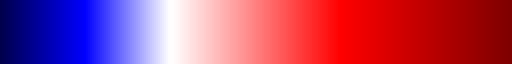

In [7]:
# updated colormaps
nrow=129
nrow2 = 2*nrow
# Relative Change Plot
colors2 = plt.cm.seismic(np.linspace(.5, 1, nrow2))

colors3 = plt.cm.seismic(np.linspace(0, .5, nrow))

# combine them and build a new colormap
colors = np.vstack((colors3, colors2))
change_map = plt_col.LinearSegmentedColormap.from_list('my_colormap', colors)
change_map

0
0
/work/Liz.Drenkard/Fe_deposition_study/static/nutrient_limitation_clims/nut_lims_GFDL-ESM4_historical_r1i1p1f1_gr_1975-2014_clim.nc
(180, 360)
1
/work/Liz.Drenkard/Fe_deposition_study/static/nutrient_limitation_clims/nut_lims_GFDL-ESM4_ssp585_r1i1p1f1_gr_2061-2100_clim.nc
(180, 360)
1
0
/work/Liz.Drenkard/Fe_deposition_study/dynamic/nutrient_limitation_clims/nut_lims_GFDL-ESM4_historical_r1i1p1f1_gr_1975-2014_clim.nc
(180, 360)
1
/work/Liz.Drenkard/Fe_deposition_study/dynamic/nutrient_limitation_clims/nut_lims_GFDL-ESM4_ssp585_r1i1p1f1_gr_2061-2100_clim.nc
(180, 360)


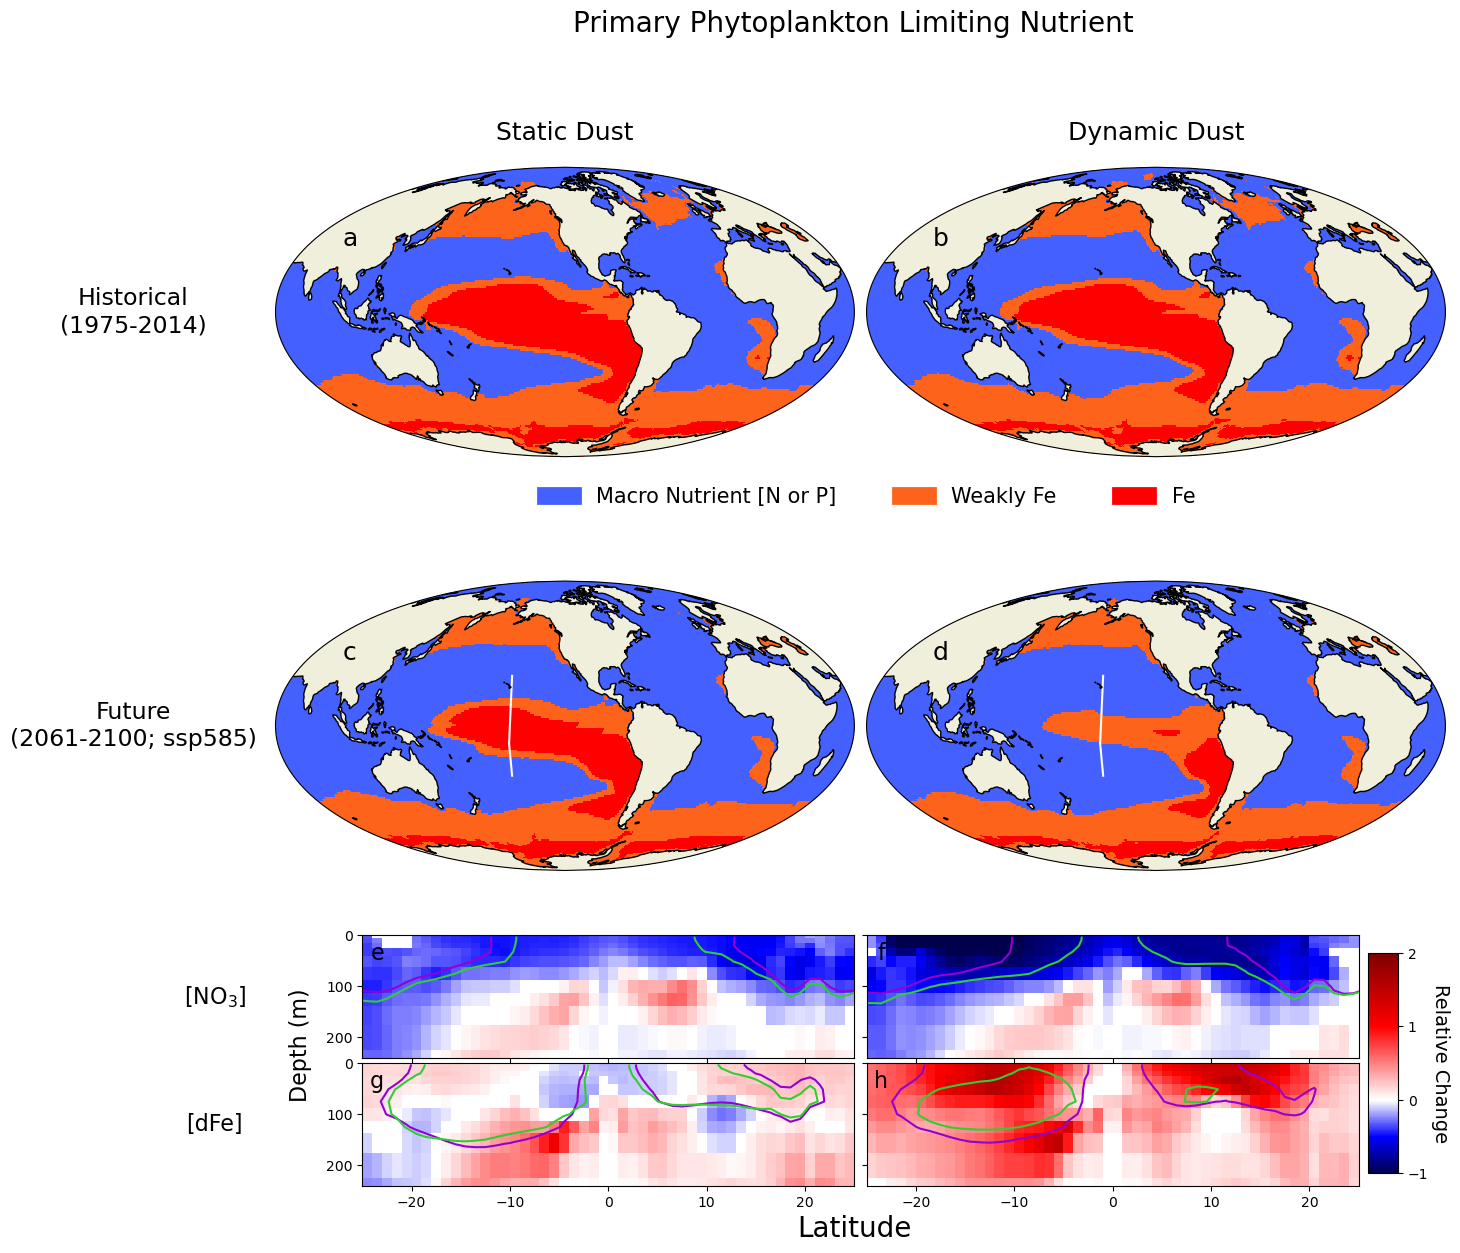

In [28]:
fig = plt.figure(figsize=(16,14))
widths=[1,10,10]
heights=[10,10,3,3]
spec = fig.add_gridspec(4, 3, wspace=0.03,hspace=0.02,height_ratios=heights,width_ratios=widths)

recalculate_limits = True

# Gets transect coordinates first time reading in a file
need_coords=True
add_transect_plots = True
# label indexing
nlab=0

# Itterate over dust symulations/ individual figures
for dst_sim, ncolp in zip(dust_sim.keys(),np.arange(2)):

    file_dir = '/work/Liz.Drenkard/Fe_deposition_study/'+ dst_sim +'/nutrient_limitation_clims/'
    print(ncolp)
    nrow = 0
    
    # Itterate over time periods
    for tim in tim_pers.keys():
        print(nrow)
        
        nut_lim_fil = 'nutrient_limitations_' + dst_sim + '_' + tim
        
        if recalculate_limits:
            # Re calculate nutrient limitation data and save as file
            data,lon_crn,lat_crn = calc_lims()
            print(data.shape)
            np.savez((nut_lim_fil),data,lon_crn,lat_crn)
            
        else:
            # open file and read in nutrient limitation results - faster for figure manipulation
            npzdata = np.load((nut_lim_fil +'.npz'))
            data = npzdata['arr_0']
            lon_crn = npzdata['arr_1']
            lat_crn = npzdata['arr_2']
        
        plot_map(data,lon_crn,lat_crn)
        nrow+=1
        nlab+=1
        
    # Add transects for Nitrate and Iron
    for nut_var in nut_var_nms:
        
        for nut_tim in mod_tims:
            ncfil = dst_sim + '/' + nut_var + '_'+ nut_tim + '_ts.nc'
            #print(ncfil)
            fid = nc.Dataset(ncfil)
                
            if need_coords: 
                lon = fid.variables['lon'][:]
                lat = fid.variables['lat'][:]
                ilon = np.where(lon==tlon)[0]
                lat_bnds = fid.variables['lat_bnds'][:] 
                clat = np.append(lat_bnds[:,0],lat_bnds[-1,-1])
                
                if dst_sim == 'dynamic':
                    lev_bnds = fid.variables['lev_bnds'][:] 
                    depth_surf = np.append(lev_bnds[:,0],lev_bnds[-1,-1])
                    depth = fid.variables['lev'][:] 
                        
                elif dst_sim == 'static':
                    depth_surf = fid.variables['z_i'][:]
                    depth = fid.variables['z_l'][:]
                
                need_coords=False
                    
            var_val_all = fid.variables[nut_var][:,:,:,ilon].squeeze()
            
            #print(nut_var, dst_sim, nut_tim, var_val_all.shape)
            # When historical, save historical values
            if nut_tim == '1975-2014_his':
                var_his = np.mean(var_val_all,axis=0)
                var_val_all_his = regress_drift_cor(var_val_all)
                    
            else:
                # store last 40 years of for analysis - after regression corrected
                var_val_all_fut = regress_drift_cor(var_val_all)[-480:,:]          
                # print(var_val_all_fut.shape)
                # average future years and compare to historical for map plot
                
                #plot percent change map
                plot_transect(var_val_all_his, var_val_all_fut)
                
                nrow+=1
                nlab+=1
            
plt.suptitle('Primary Phytoplankton Limiting Nutrient',x=.53,y=0.95,fontsize=20)
plt.savefig('Figure2')
